In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, adjusted_rand_score, silhouette_score, accuracy_score,
    ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, 
    f1_score, davies_bouldin_score, calinski_harabasz_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import umap.umap_ as umap
from scipy.stats import mode

# BioInformatica #2

## Data Spliting

In [36]:
df_X = pd.read_csv('X_gexp.csv', index_col=0)
df_Y = pd.read_csv('y_gexp.csv', index_col=0)
df_X.head()

,FSTL1,ELMO2,CREB3L1,PNMA1,MMP2,SMARCD3,PKNOX2,RALYL,ZHX3,APBB2,...,ST18,PSMB9,ProSAPiP1,HCLS1,MMP9,KIAA0802,DHRS2,SGEF,PIK3IP1,CTSC
TCGA-02-0001-01,2.275179,1.873549,1.772059,2.144198,2.269443,1.742389,1.797055,1.677848,1.801352,1.786488,...,1.669895,2.346811,2.004333,2.213310,2.407606,2.083333,2.098461,1.680092,1.953595,2.429578
TCGA-02-0004-01,2.569520,2.085888,1.961846,2.315705,2.505400,2.226593,1.798769,1.671170,2.000942,2.089285,...,1.516024,2.339930,2.045828,2.285701,2.633632,1.938474,1.614437,1.760419,2.010156,2.431814
TCGA-02-0009-01,2.471492,2.030865,1.845808,2.072279,2.346815,1.783762,1.707150,1.599492,1.823480,1.778307,...,1.527561,2.302006,2.059862,2.130193,2.349831,1.815239,1.857933,1.675823,2.011970,2.434026
TCGA-02-0015-01,2.464403,2.094165,1.762169,2.374129,2.213562,2.209426,1.925440,1.936043,2.003743,2.024847,...,1.611626,2.208924,2.050555,2.213955,1.982603,2.125508,1.631955,1.881003,1.886280,2.450704
TCGA-02-0016-01,2.365457,2.188070,1.763206,2.340024,2.219210,2.308335,1.801007,1.756726,2.115714,2.086733,...,1.570489,2.187420,2.265522,2.192262,1.796491,1.979615,1.637215,2.182186,1.897957,2.140727


In [37]:
df_X.shape

(302, 5000)

In [38]:
df_X.isna().sum()

FSTL1       0
ELMO2       0
CREB3L1     0
PNMA1       0
MMP2        0
           ..
KIAA0802    0
DHRS2       0
SGEF        0
PIK3IP1     0
CTSC        0
Length: 5000, dtype: int64

In [39]:
df_Y.shape

(302, 1)

## Data Pre Processing

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

## Feature selection

Initialize the dictionary that will contain the df_X resultant of all feature selection methods used. We set the maximum of features to be 500 (10% of the original dataset).

In [41]:
feature_reductions = {}

Minimal Variance Treshold:

* Removes low-variance features (assumes features are on the same scale).

* If features are not scaled, variance will be biased toward features with larger magnitudes.

* Needs StandardScaler before applying.

The treshold means ....., and by increasing this hyperparanter the number of features decreases.

In [42]:
variance = VarianceThreshold(threshold=1.0) 
X_filtered = variance.fit_transform(X_scaled)
selected_features_variance = df_X.columns[variance.get_support()]


if len(selected_features_variance) > 500:
    variances = np.var(X_scaled[:, variance.get_support()], axis=0)
    top_indices = np.argsort(variances)[-500:]
    selected_features_variance = selected_features_variance[top_indices]

x = df_X[selected_features_variance]
print(f"Variance Threshold selected {x.shape[1]} features (max 500)")
feature_reductions["Variance Threshold"] = x

Variance Threshold selected 500 features (max 500)


Principal Component Analysis (PCA)

In [43]:
X_scaled

array([[-1.61541726, -2.23798928, -0.00604086, ..., -1.51465683,
         0.10232217,  0.87514277],
       [ 2.07907233,  0.07910029,  2.30928791, ..., -0.93692894,
         0.79055191,  0.89346788],
       [ 0.84864836, -0.52132144,  0.89366589, ..., -1.54535885,
         0.8126301 ,  0.91159891],
       ...,
       [ 0.79486166,  0.75955381,  0.95854425, ...,  0.89171421,
         1.04858882,  0.59905307],
       [-0.25045722,  0.71322605,  2.38188082, ...,  0.11731145,
        -1.11731078, -1.0236637 ],
       [ 0.41451037,  1.24166686,  3.45546485, ...,  1.8357462 ,
         0.00751842, -0.96669954]], shape=(302, 5000))

In [44]:
pca = PCA(n_components=0.99, random_state=42)
X_pca = pca.fit_transform(X_scaled)

y = pd.DataFrame(X_pca, index=df_X.index, 
                columns=[f"PC_{i+1}" for i in range(pca.n_components_)])
print(f"PCA kept {y.shape[1]} components")
feature_reductions["PCA"] = y

PCA kept 265 components


ANOVA F-test

* Measures the relationship between each feature and the target variable (categorical).

* Based on variance ratios, not absolute values.

* Does not need StandardScaler.

In [45]:
k = min(500, df_X.shape[1])
anova = SelectKBest(score_func=f_classif, k=k)
X_selected = anova.fit_transform(df_X, df_Y)
selected_features_anova = df_X.columns[anova.get_support()]
z = df_X[selected_features_anova]
print(f"ANOVA selected {z.shape[1]} features")
feature_reductions["ANOVA"] = z

ANOVA selected 500 features


Correlation with the Target Variable

* Does not use StandardScaler

In [46]:
target_correlation = pd.concat([df_X, df_Y], axis=1).corr()[df_Y.columns[0]].abs()
target_correlation = target_correlation.drop(df_Y.columns[0]).sort_values(ascending=False)
top_n = min(500, len(target_correlation))  
selected_features_correlation = target_correlation.head(top_n).index
w = df_X[selected_features_correlation]
print(f"Correlation selected {w.shape[1]} features")
feature_reductions["Correlation"] = w

Correlation selected 500 features


In [47]:
feature_reductions["None"] = df_X

Methods applied

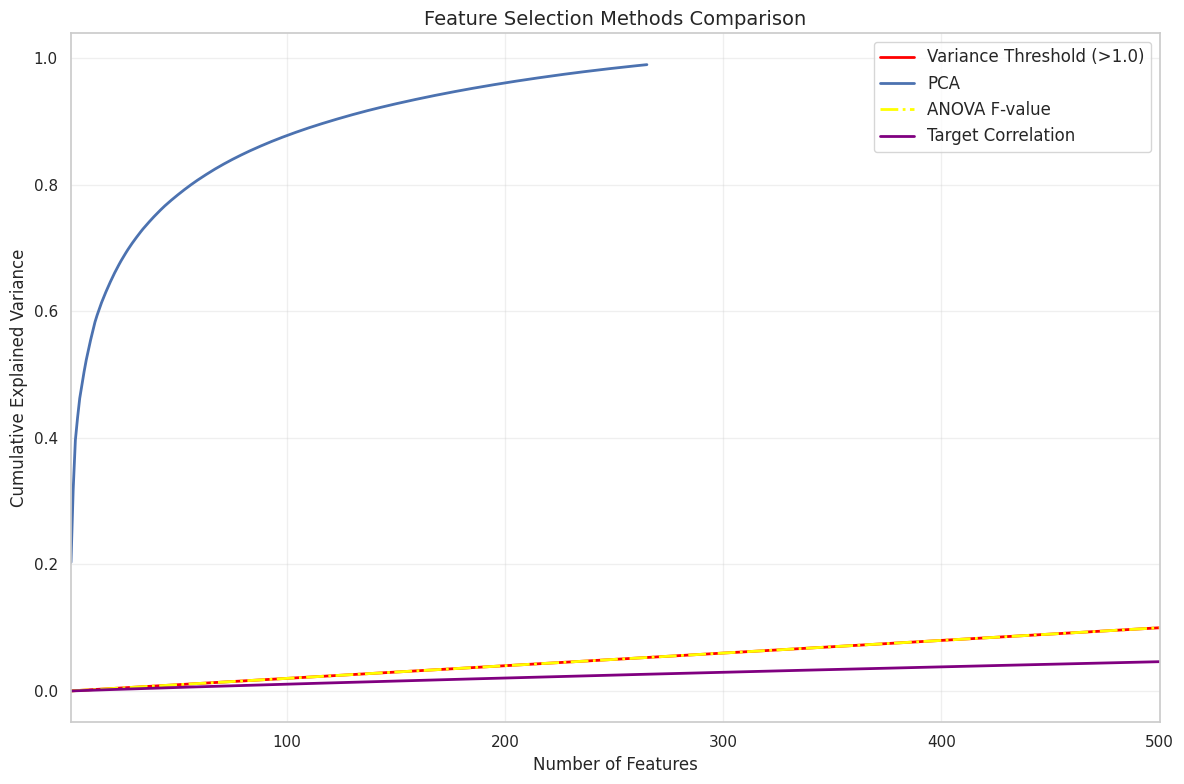

In [48]:
plt.figure(figsize=(12, 8))

# --- 1. VarianceThreshold ---
selected_variances = np.var(X_scaled[:, variance.get_support()], axis=0)
sorted_selected_variances = np.sort(selected_variances)[::-1]
cumulative_variance_selected = np.cumsum(sorted_selected_variances) / np.sum(np.var(X_scaled, axis=0))
plt.plot(range(1, len(cumulative_variance_selected)+1), 
         cumulative_variance_selected, linestyle='-',  color="red",
         label='Variance Threshold (>1.0)', linewidth=2)

# --- 2. PCA ---
pca_cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, min(501, len(pca_cumulative)+1)), 
         pca_cumulative[:500], linestyle='-',
         label='PCA', linewidth=2)

# --- 3. ANOVA ---
anova_scores = anova.scores_
sorted_indices = np.argsort(anova_scores)[::-1]
sorted_variances_anova = np.var(X_scaled, axis=0)[sorted_indices]
cumulative_variance_anova = np.cumsum(sorted_variances_anova) / np.sum(np.var(X_scaled, axis=0))
plt.plot(range(1, min(501, len(cumulative_variance_anova)+1)), 
         cumulative_variance_anova[:500], linestyle='-.', color="yellow",
         label='ANOVA F-value', linewidth=2)

# --- 4. Target Correlation ---
cumulative_variance_corr = np.cumsum(target_correlation) / np.sum(np.var(X_scaled, axis=0))
plt.plot(range(1, min(501, len(cumulative_variance_corr)+1)), 
         cumulative_variance_corr[:500], linestyle='-', color="purple",
         label='Target Correlation', linewidth=2)

# --- Final plot customization ---
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Feature Selection Methods Comparison', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1, min(500, X_scaled.shape[1]))
plt.tight_layout()
plt.show()



Selected features by type of method

In [49]:
print(feature_reductions)

{'Variance Threshold':                      NAV2      SCG2      KLK7     ATXN7     CEP63     NTSR2  \
TCGA-02-0001-01  2.215275  1.887834  1.730437  1.877004  1.803601  1.632311   
TCGA-02-0004-01  2.100200  2.346226  1.623967  1.746630  2.090638  1.850370   
TCGA-02-0009-01  1.901059  2.079891  1.845552  1.736971  1.939237  1.639980   
TCGA-02-0015-01  2.210773  2.493276  1.614682  1.653307  1.948266  1.642109   
TCGA-02-0016-01  2.264473  2.359501  1.625020  1.874049  1.971226  2.307697   
...                   ...       ...       ...       ...       ...       ...   
TCGA-76-4931-01  2.281648  2.153420  1.653830  1.801379  1.991497  1.916533   
TCGA-76-6193-01  2.275639  2.263439  1.630903  1.811739  2.066924  1.901442   
TCGA-76-6282-01  2.258022  2.338533  1.637654  1.781990  2.058646  1.701202   
TCGA-81-5910-01  2.309625  2.378268  1.681708  1.757912  2.089266  1.664303   
TCGA-87-5896-01  2.089991  2.519974  1.654914  1.752212  2.073572  1.799372   

                     THRA  C

## Model training & testing

### Unsupervised Learning

Dimensionality reduction techniques (PCA and UMAP).

In [50]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

Clustering algorithms (K-means and Agglomerative Clustering)

In [51]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

agg = AgglomerativeClustering(n_clusters=2)
agg_labels = agg.fit_predict(X_scaled)

Evaluation metrics

In [52]:
y = df_Y.squeeze()

In [64]:
def get_clustering_metrics(X_data, y_true, cluster_labels):
    return {
        "Accuracy": accuracy_score(y_true, cluster_labels),
        "Precision": precision_score(y_true, cluster_labels),
        "Recall": recall_score(y_true, cluster_labels),
        "F1": f1_score(y_true, cluster_labels),
        "ARI": adjusted_rand_score(y_true, cluster_labels),
        "Silhouette": silhouette_score(X_data, cluster_labels),
        "DBI": davies_bouldin_score(X_data, cluster_labels),
        "Calinski-Harabasz": calinski_harabasz_score(X_data, cluster_labels),
        "Homogeneity": homogeneity_score(y_true, cluster_labels),
        "Completeness": completeness_score(y_true, cluster_labels),
        "V-Measure": v_measure_score(y_true, cluster_labels)
    }

all_cluster_results = {
    "KMeans": get_clustering_metrics(X_scaled, y, kmeans_labels),
    "Agglomerative": get_clustering_metrics(X_scaled, y, agg_labels)
}

metric_order = [
    'Accuracy', 'Precision', 'Recall', 'F1',         # Classification metrics
    'ARI',                                           # Clustering similarity
    'Silhouette', 'DBI', 'Calinski-Harabasz',        # Internal clustering metrics
    'Homogeneity', 'Completeness', 'V-Measure'       # Cluster-to-class metrics
]

cluster_results_table = pd.DataFrame(all_cluster_results).loc[metric_order]

cluster_results_styled = cluster_results_table.style \
    .format("{:.3f}") \
    .set_caption("Clustering Evaluation Metrics") \
    

display(cluster_results_styled)

,KMeans,Agglomerative
Accuracy,0.609,0.464
Precision,0.623,0.472
Recall,0.631,0.268
F1,0.627,0.341
ARI,0.045,0.002
Silhouette,0.106,0.099
DBI,2.547,2.345
Calinski-Harabasz,42.381,39.350
Homogeneity,0.034,0.003
Completeness,0.034,0.003


In [54]:
results = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'UMAP1': X_umap[:, 0],
    'UMAP2': X_umap[:, 1],
    'KMeans': kmeans_labels,
    'Agglomerative': agg_labels,
    'TrueLabel': y
})

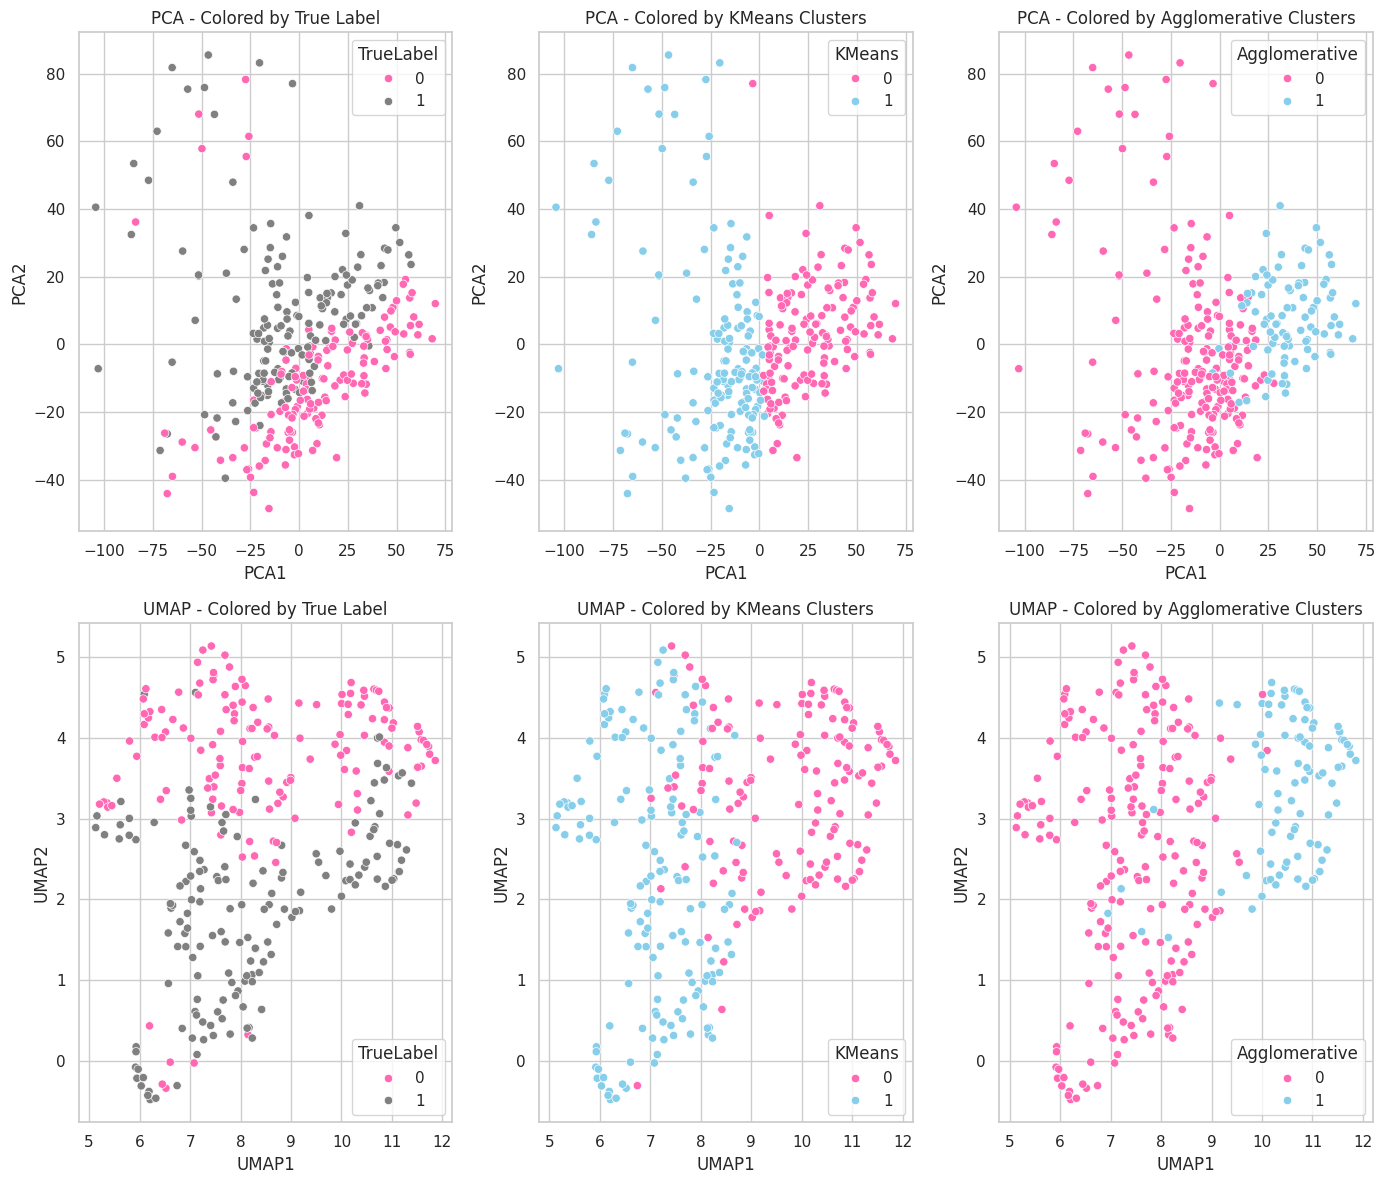

In [55]:
true_palette = {0: 'hotpink', 1: 'gray', 2: 'lightblue', 3: 'green', 4: 'orange'} 
cluster_palette = {0: 'hotpink', 1: 'skyblue', 2: 'limegreen', 3: 'orange', 4: 'purple'}

fig, axes = plt.subplots(2, 3, figsize=(14, 12))

sns.scatterplot(data=results, x='PCA1', y='PCA2', hue='TrueLabel', palette=true_palette, ax=axes[0, 0])
axes[0, 0].set_title('PCA - Colored by True Label')

sns.scatterplot(data=results, x='PCA1', y='PCA2', hue='KMeans', palette=cluster_palette, ax=axes[0, 1])
axes[0, 1].set_title('PCA - Colored by KMeans Clusters')

sns.scatterplot(data=results, x='PCA1', y='PCA2', hue='Agglomerative', palette=cluster_palette, ax=axes[0, 2])
axes[0, 2].set_title('PCA - Colored by Agglomerative Clusters')

sns.scatterplot(data=results, x='UMAP1', y='UMAP2', hue='TrueLabel', palette=true_palette, ax=axes[1, 0])
axes[1, 0].set_title('UMAP - Colored by True Label')

sns.scatterplot(data=results, x='UMAP1', y='UMAP2', hue='KMeans', palette=cluster_palette, ax=axes[1, 1])
axes[1, 1].set_title('UMAP - Colored by KMeans Clusters')

sns.scatterplot(data=results, x='UMAP1', y='UMAP2', hue='Agglomerative', palette=cluster_palette, ax=axes[1, 2])
axes[1, 2].set_title('UMAP - Colored by Agglomerative Clusters')

plt.tight_layout()
plt.show()


### Supervised Learning

In [56]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "QDA": QuadraticDiscriminantAnalysis(),
    "MLP": MLPClassifier(max_iter=1000),
    "SVM": SVC(kernel="rbf", probability=True),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


kf = StratifiedKFold(n_splits=5, shuffle=True)

warnings.filterwarnings("ignore")

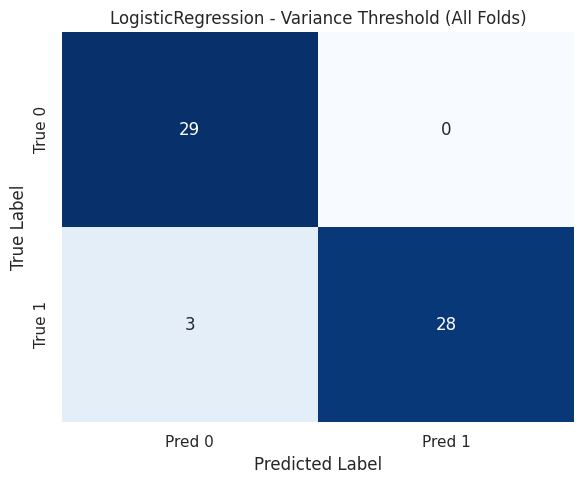

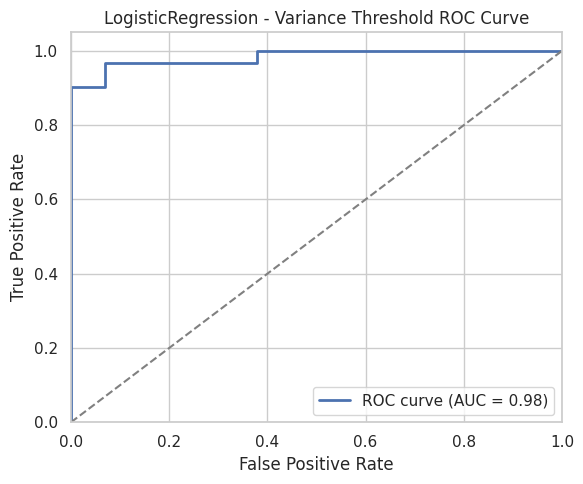

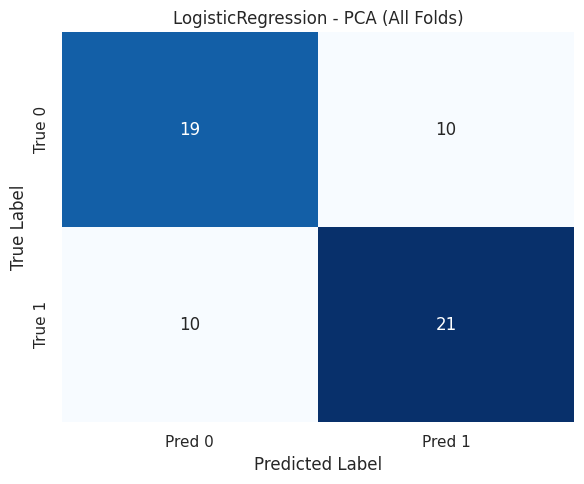

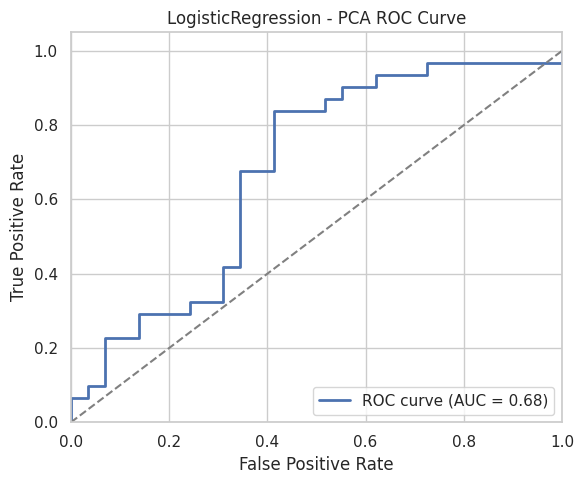

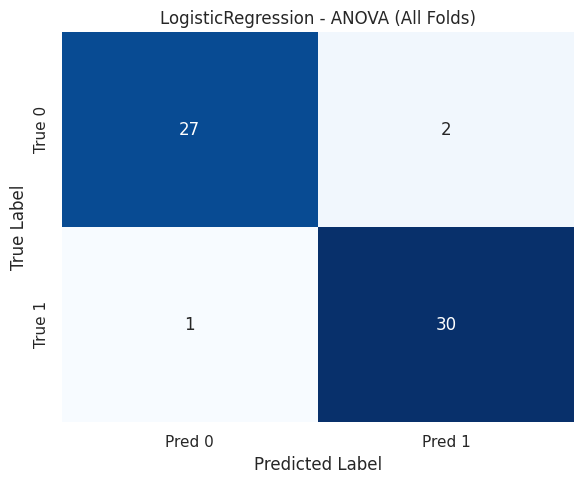

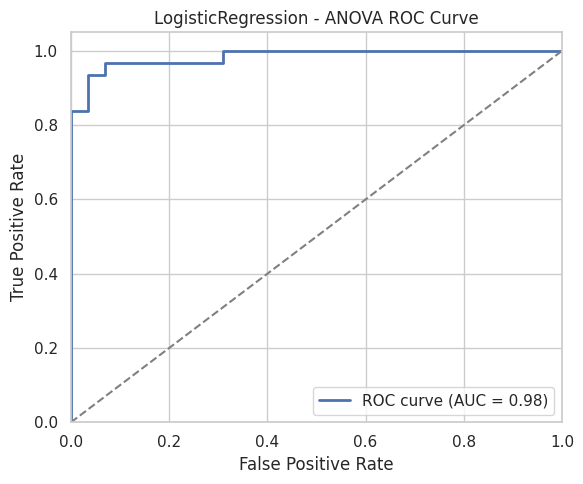

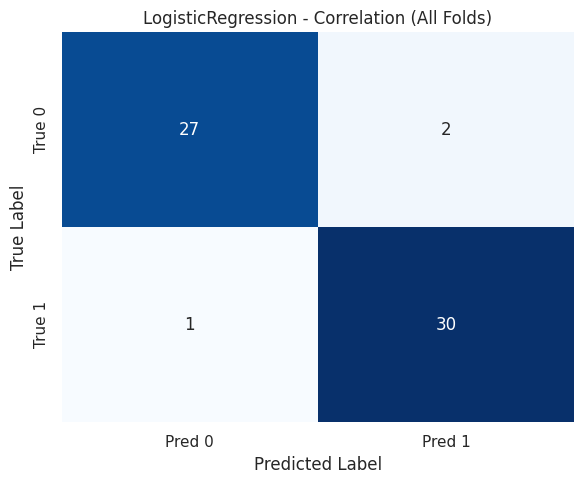

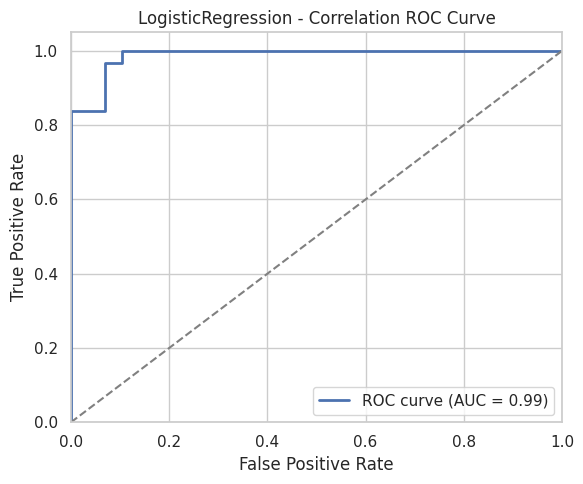

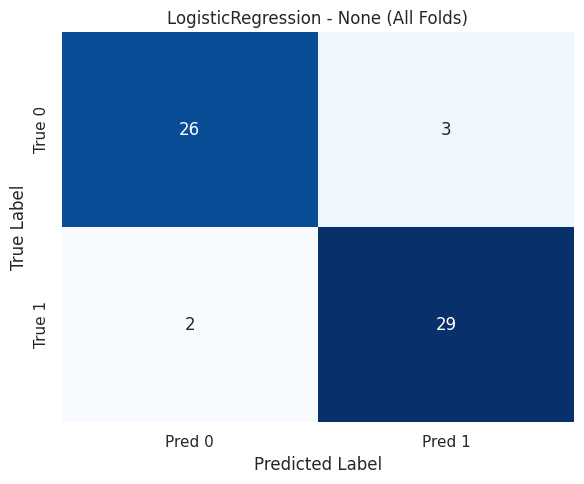

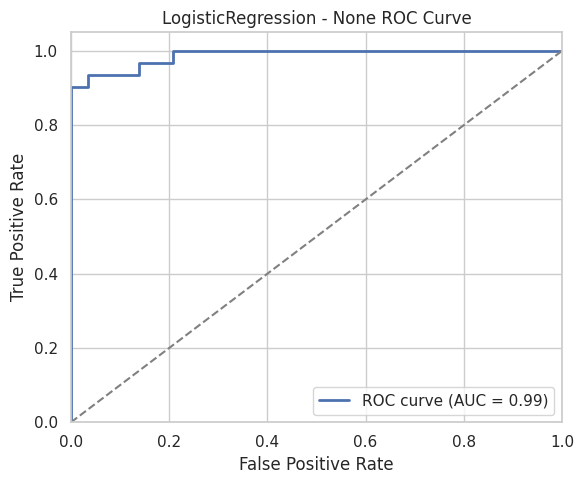

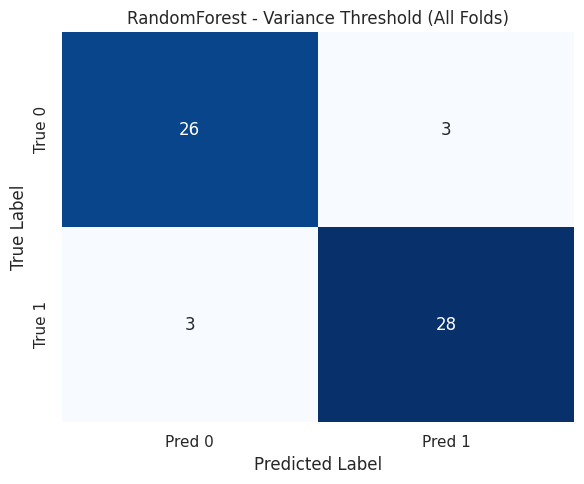

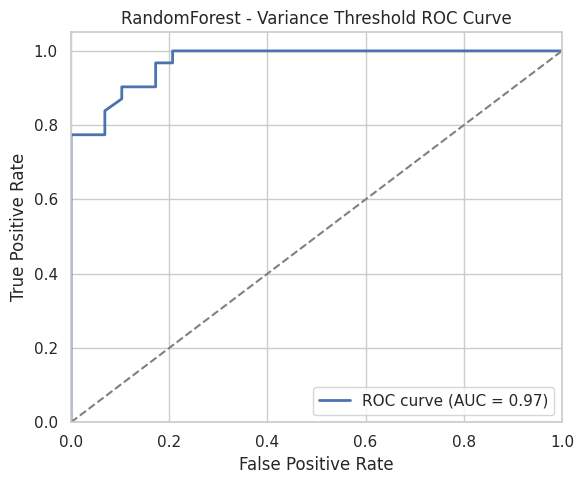

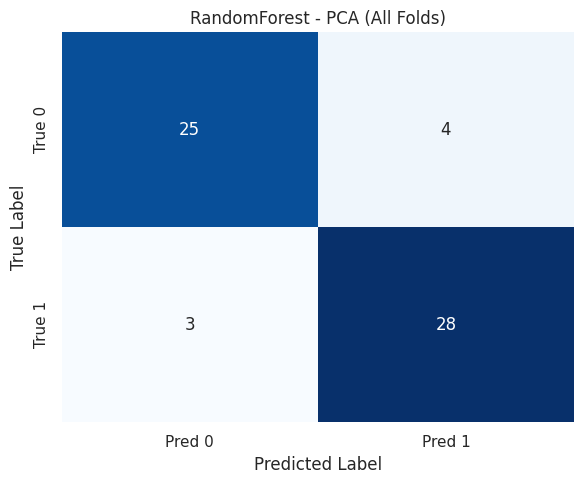

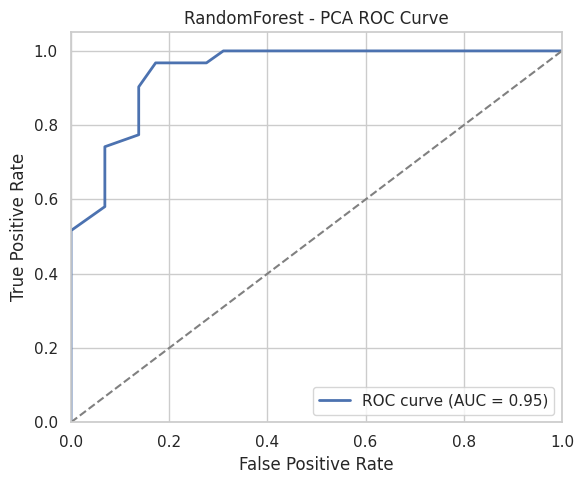

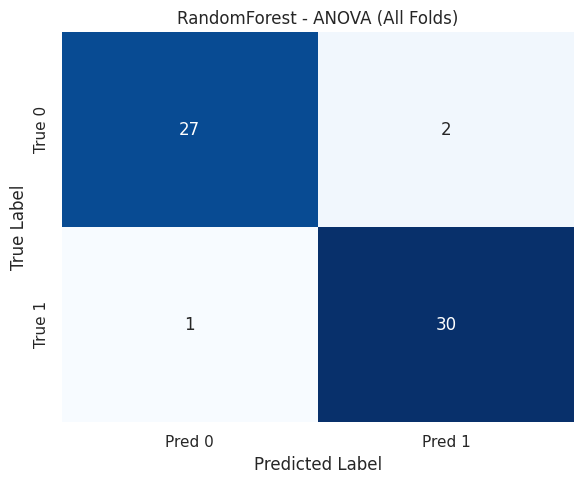

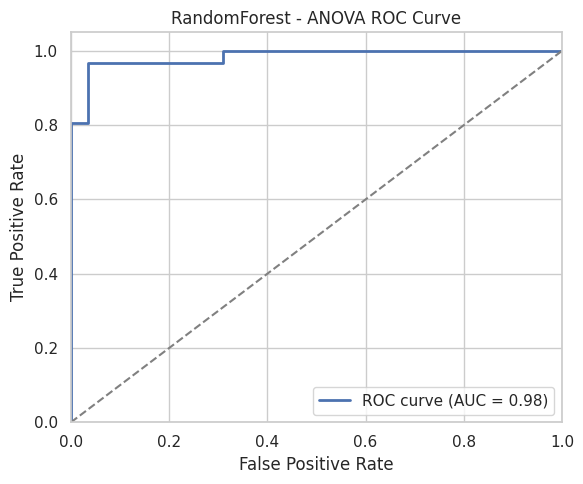

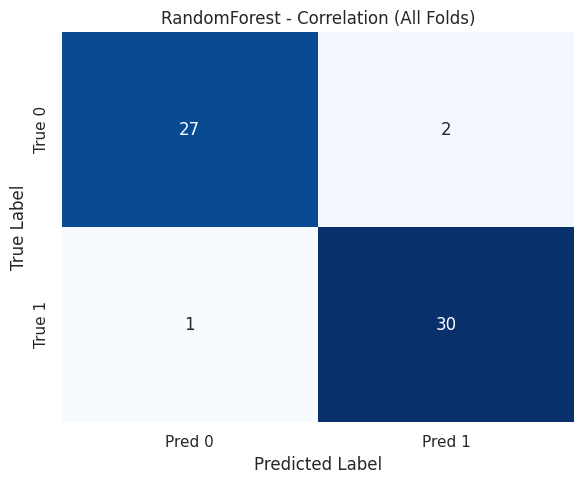

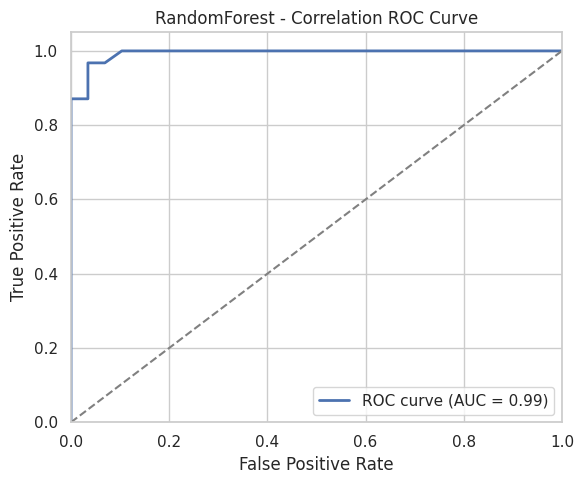

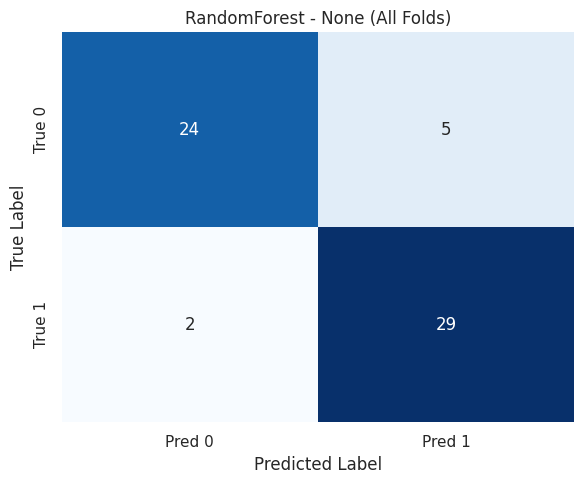

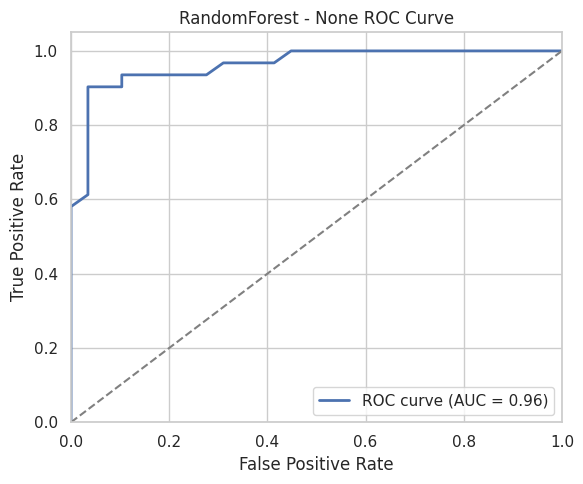

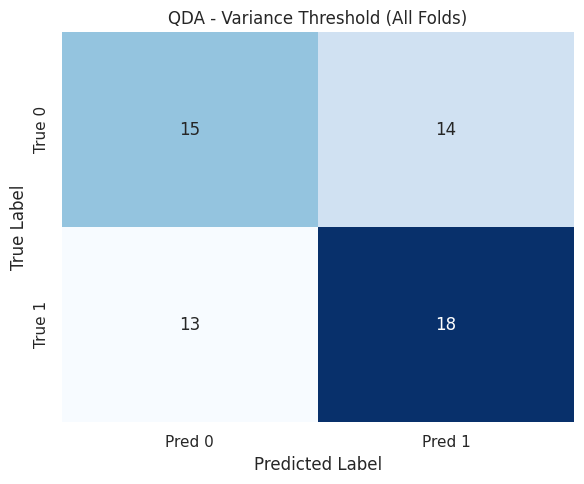

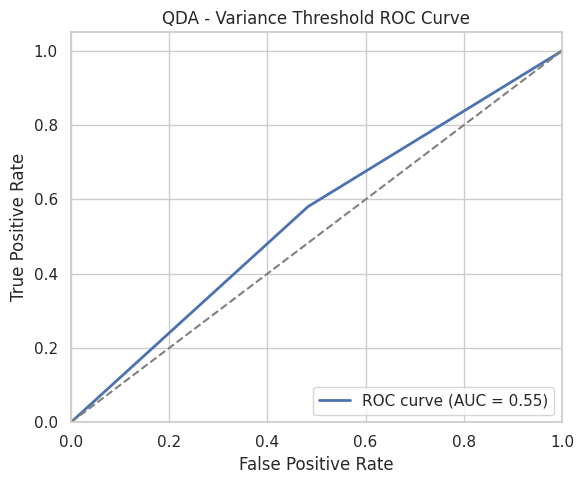

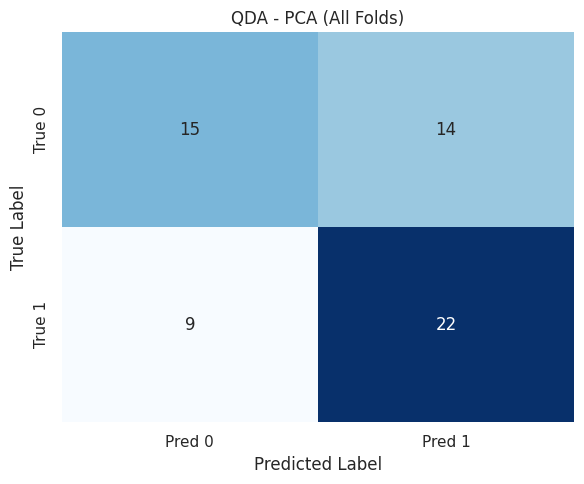

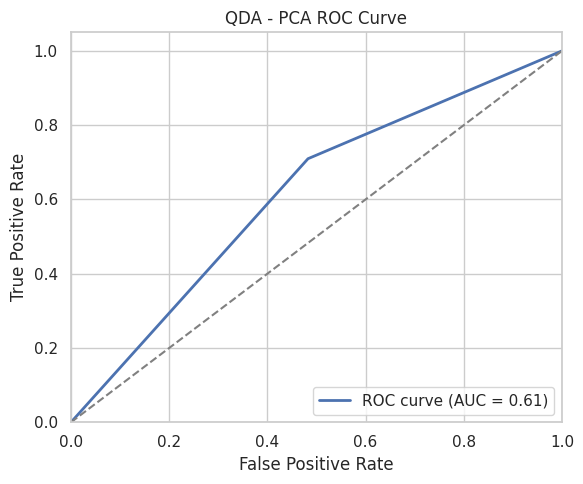

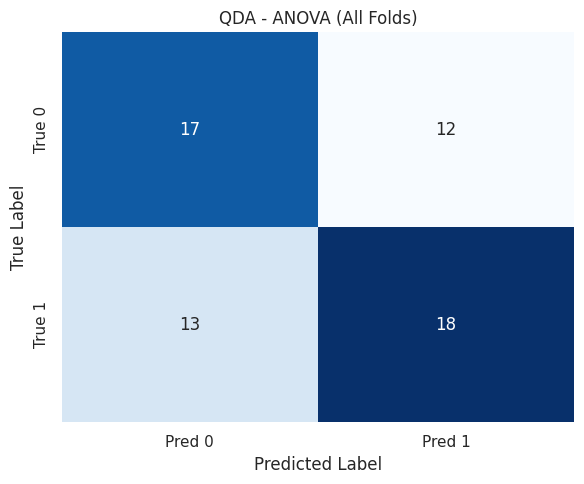

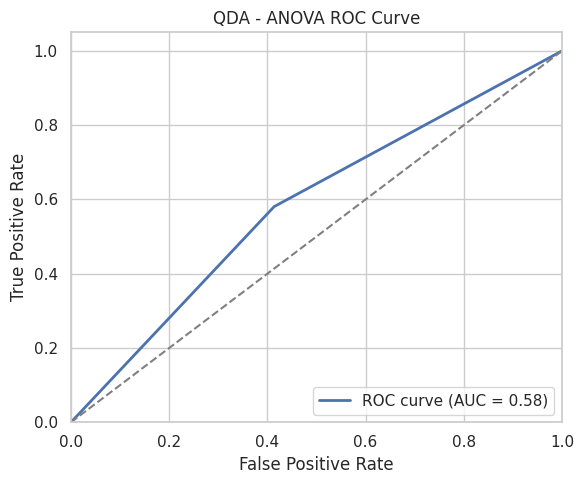

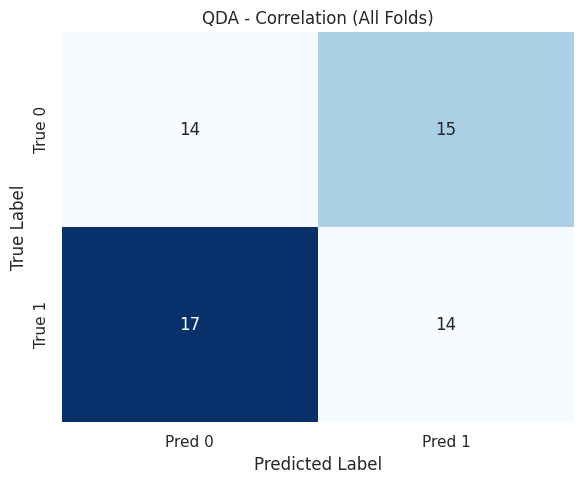

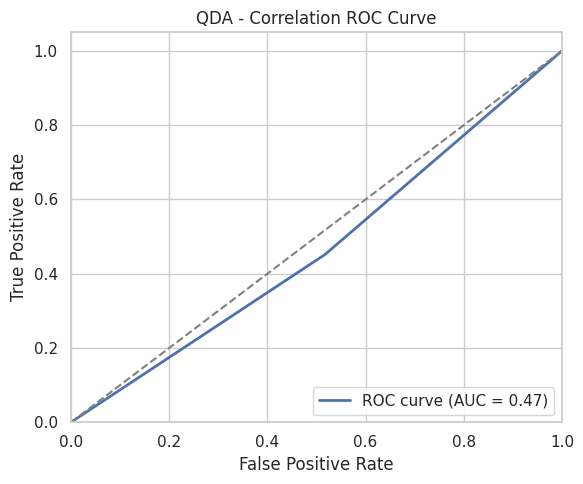

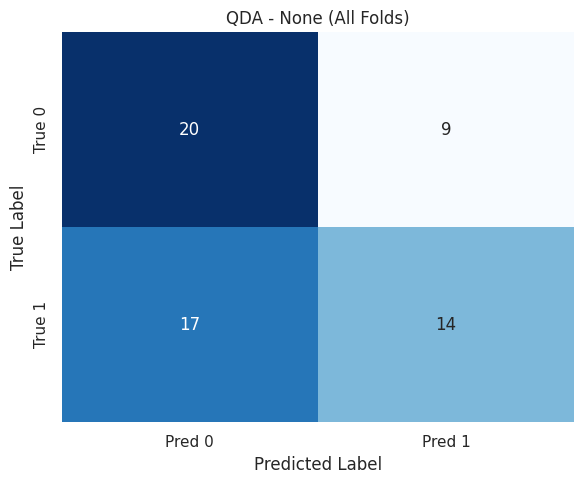

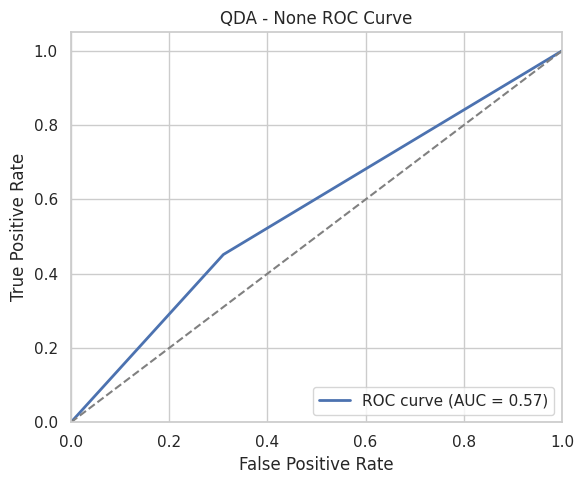

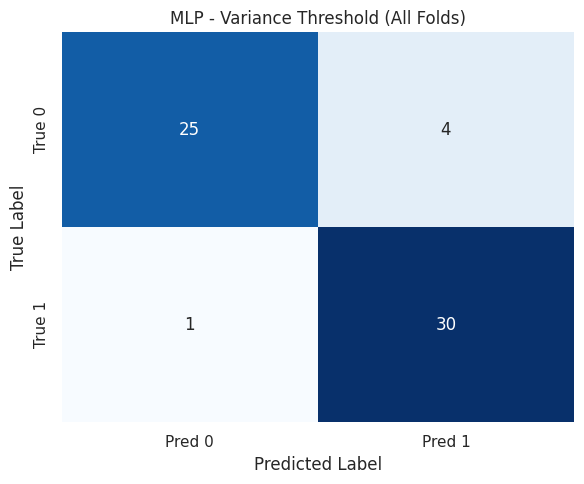

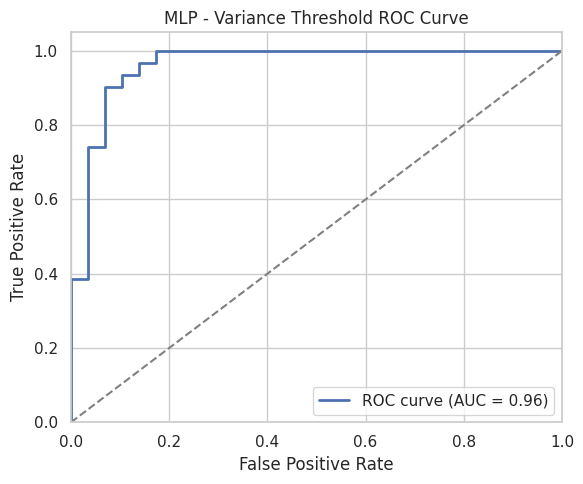

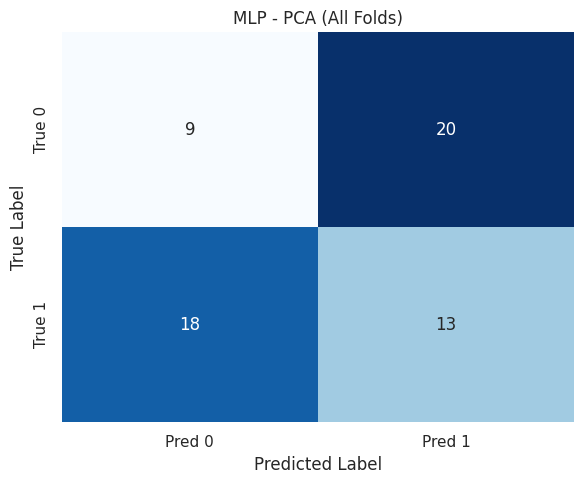

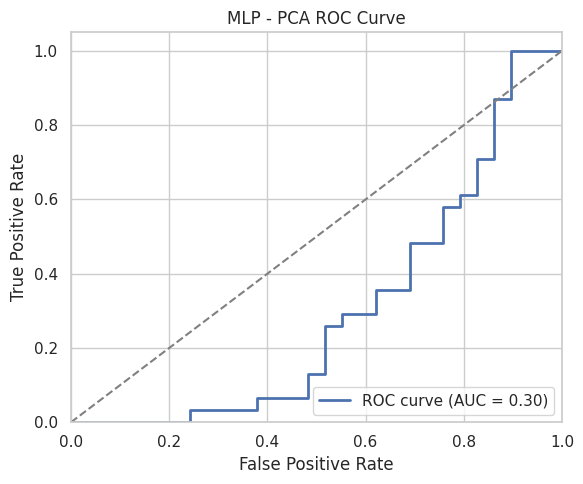

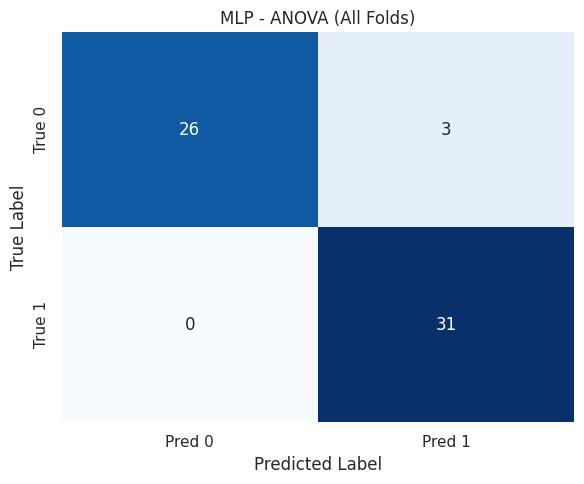

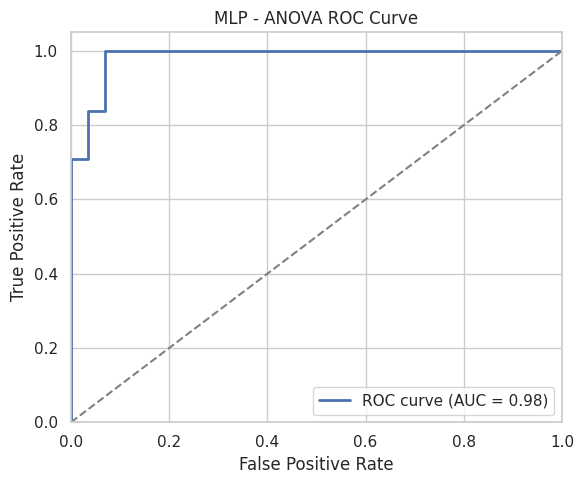

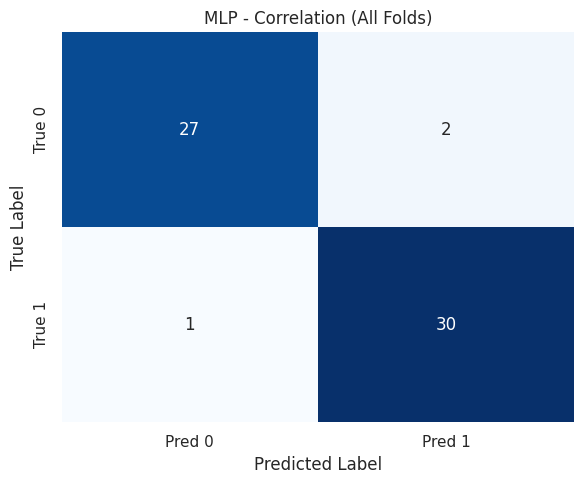

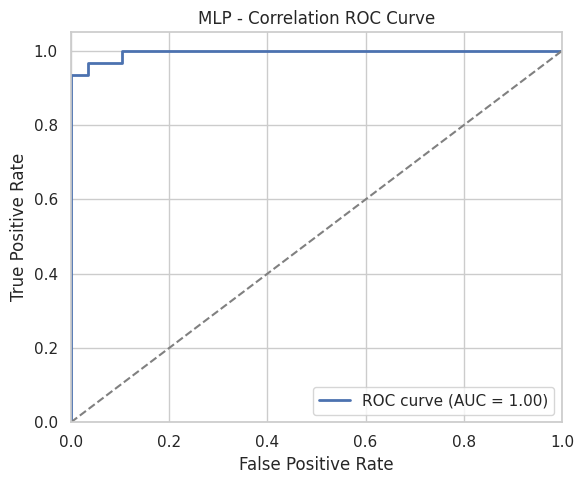

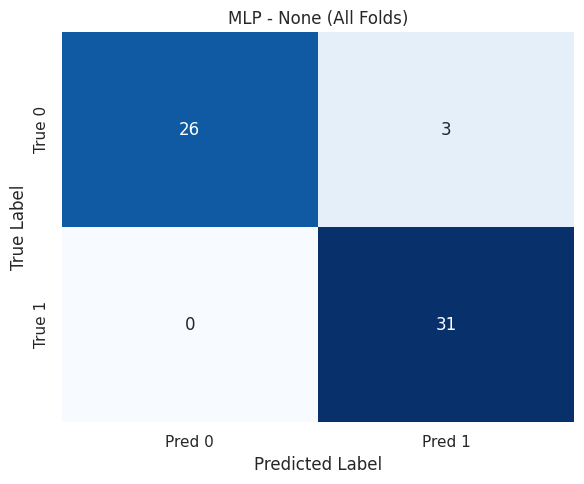

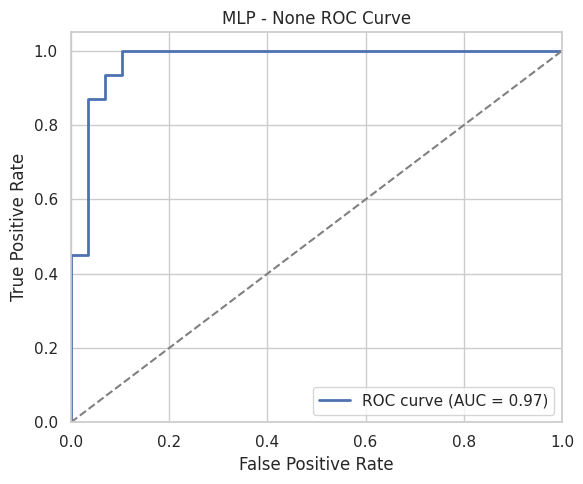

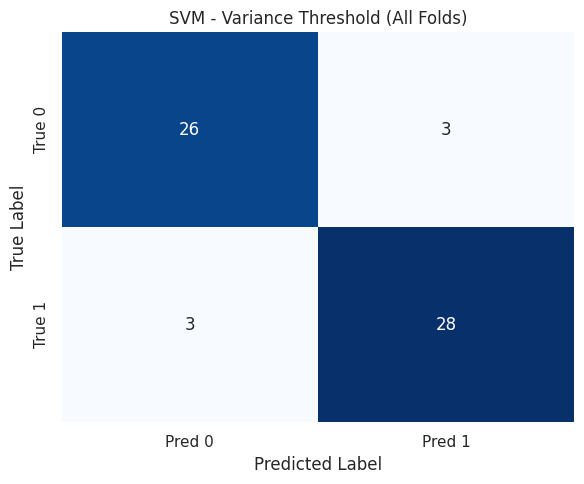

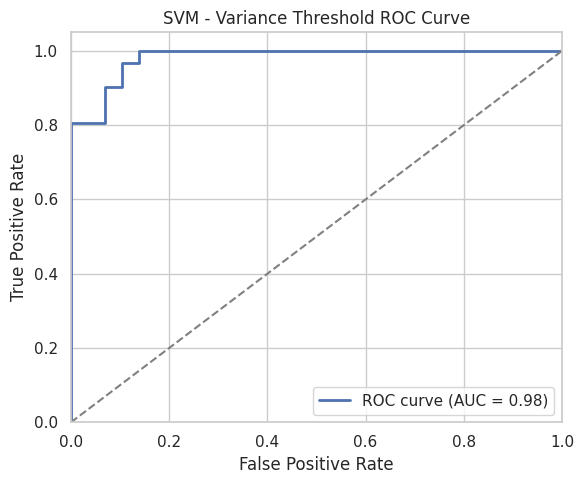

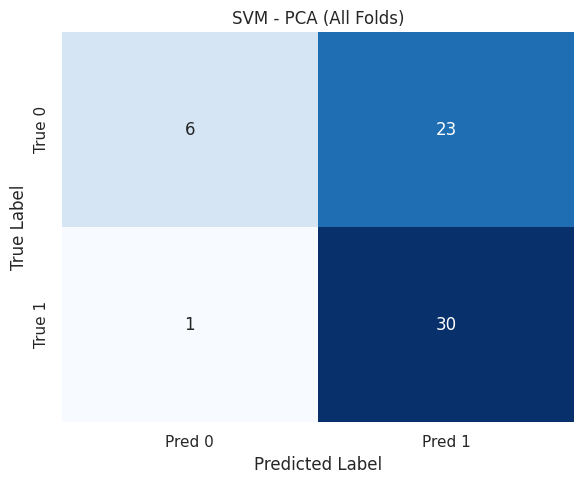

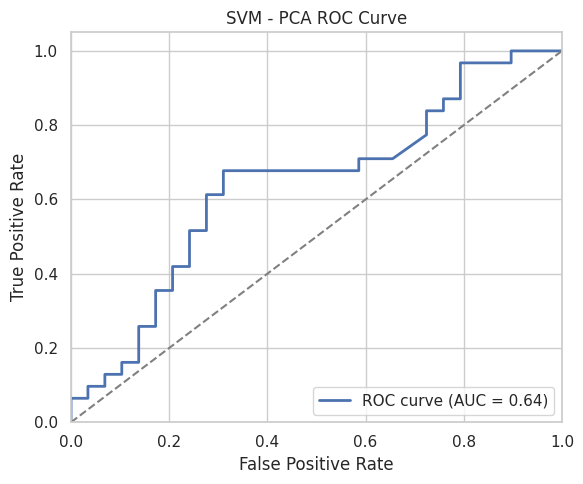

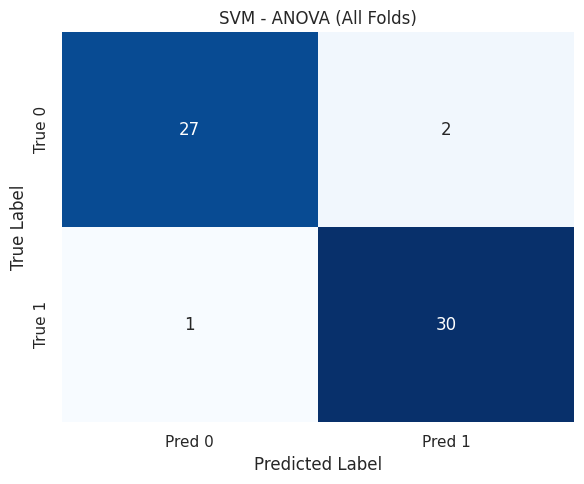

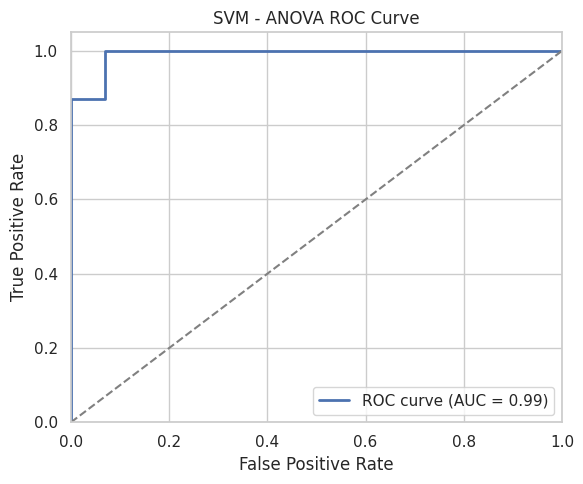

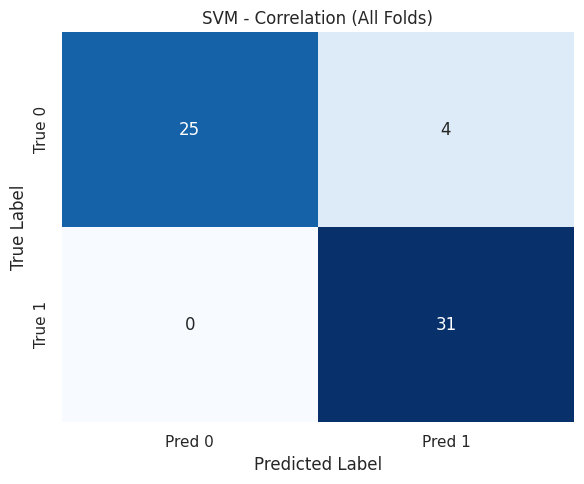

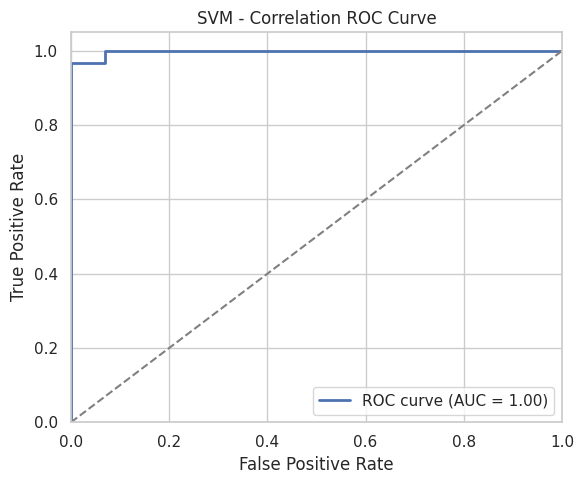

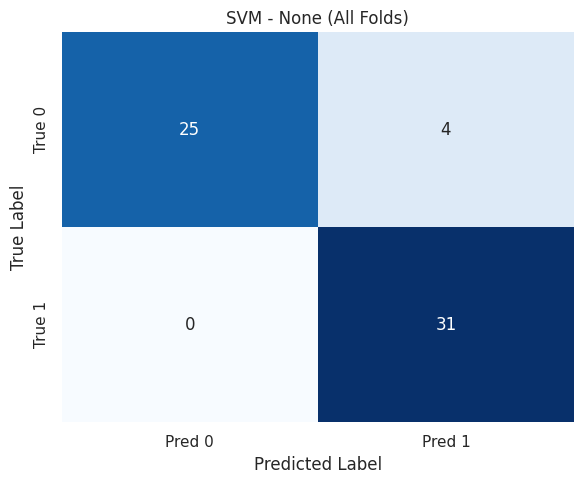

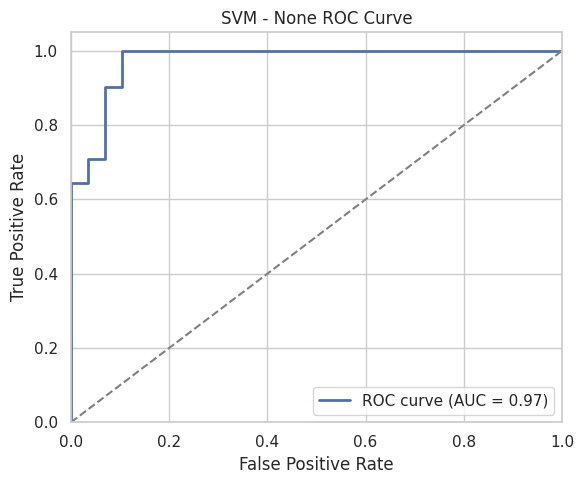

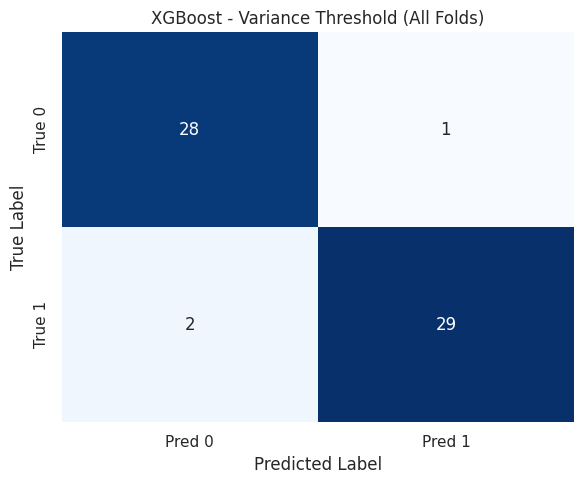

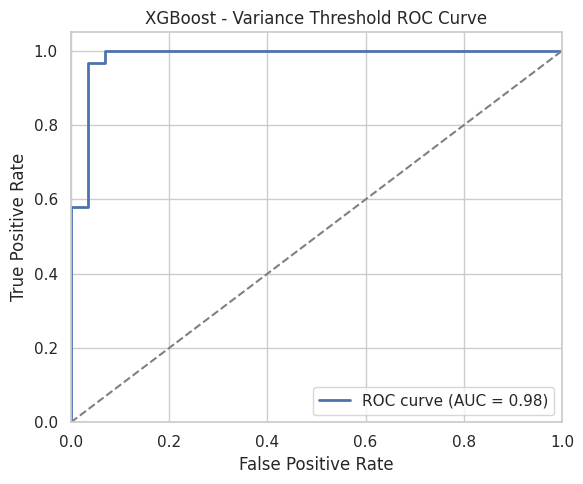

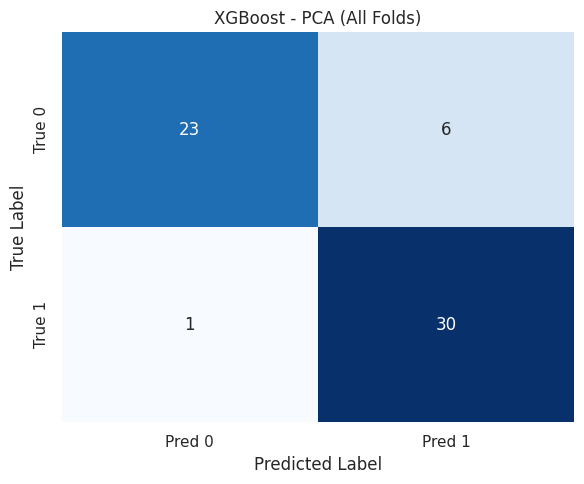

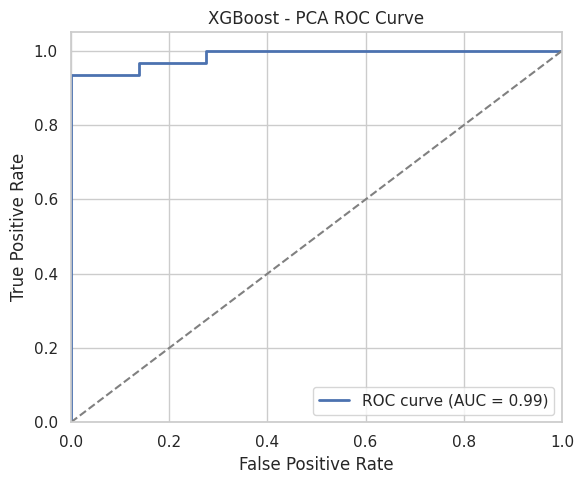

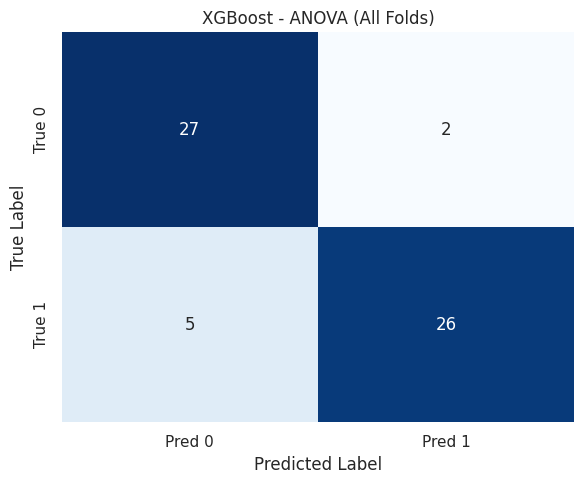

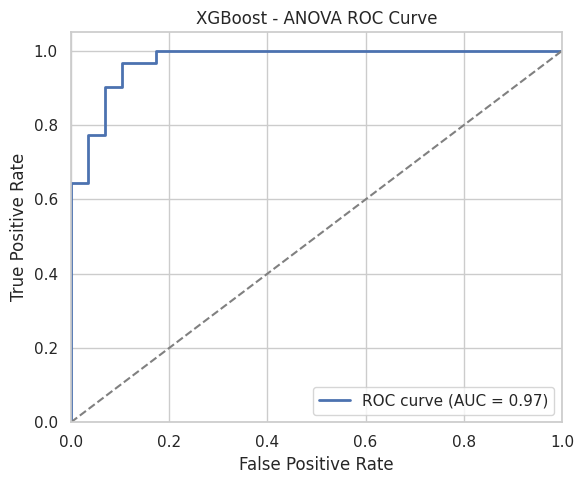

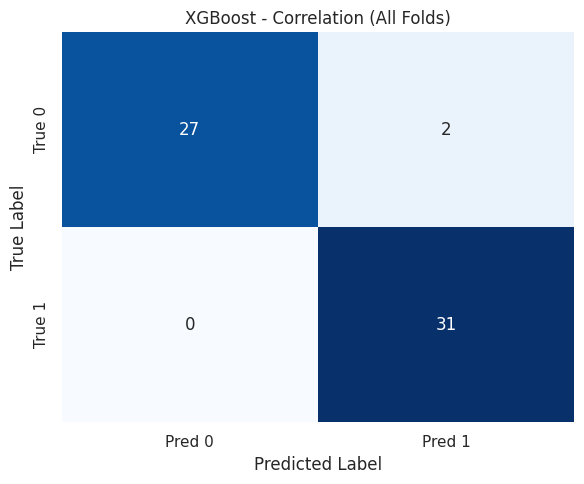

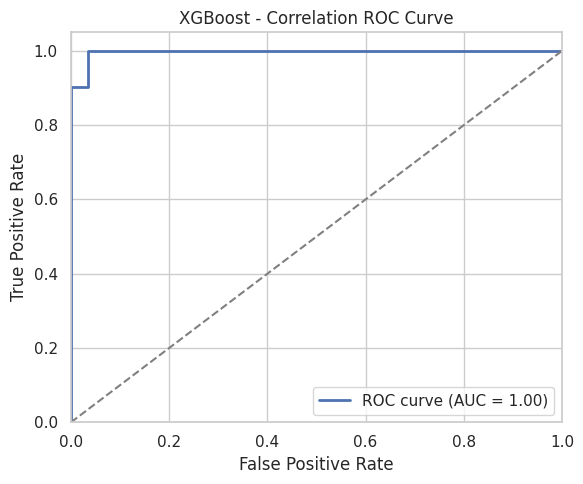

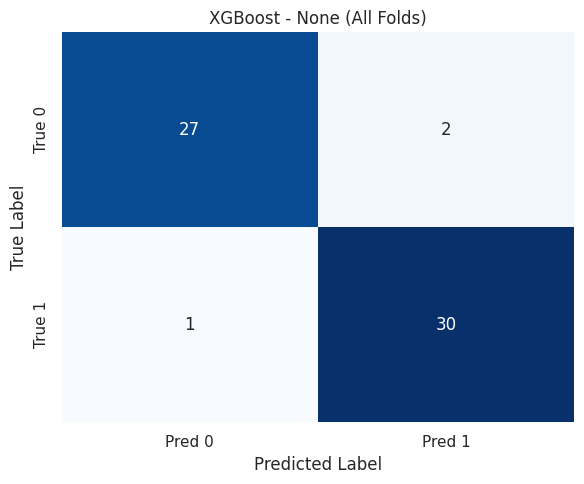

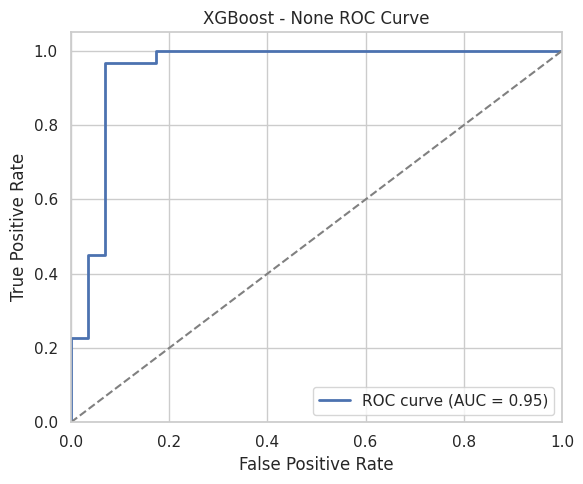

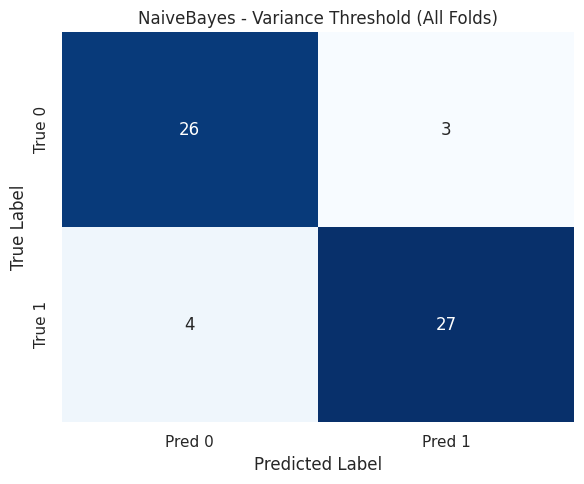

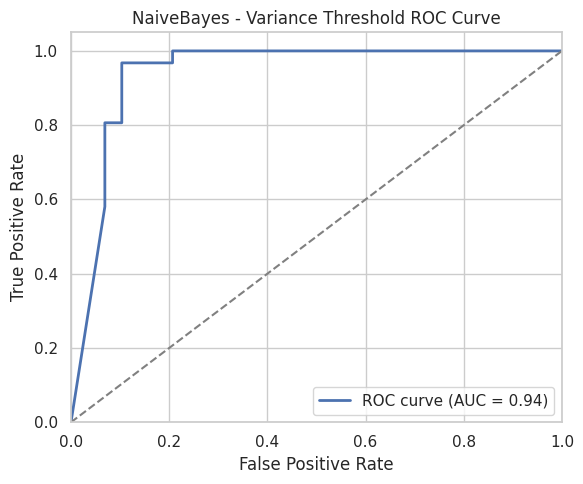

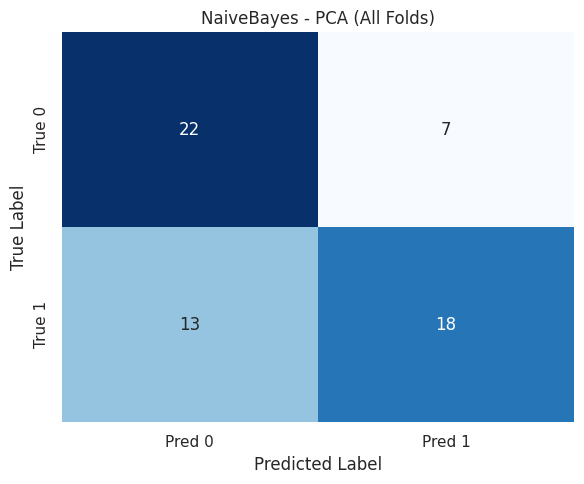

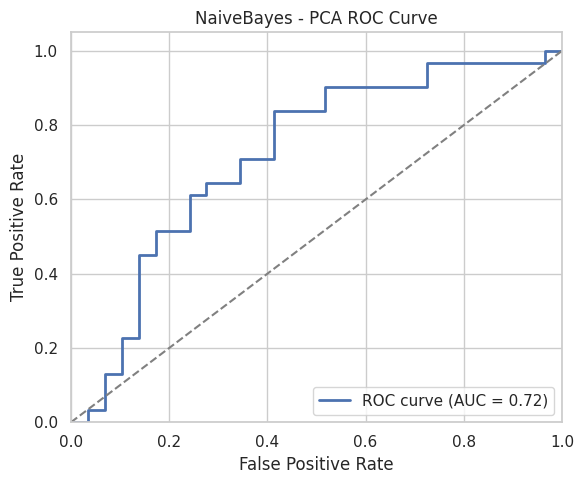

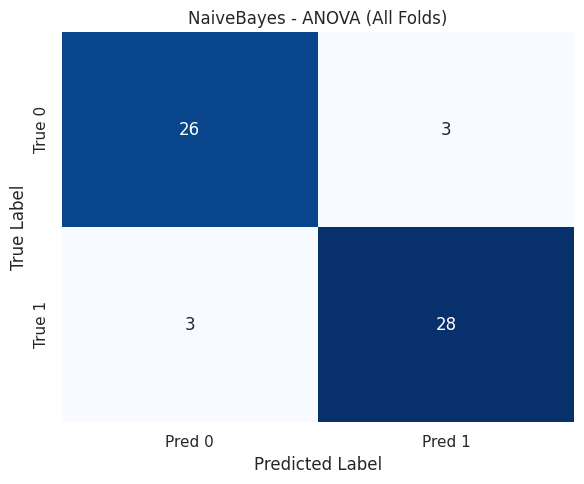

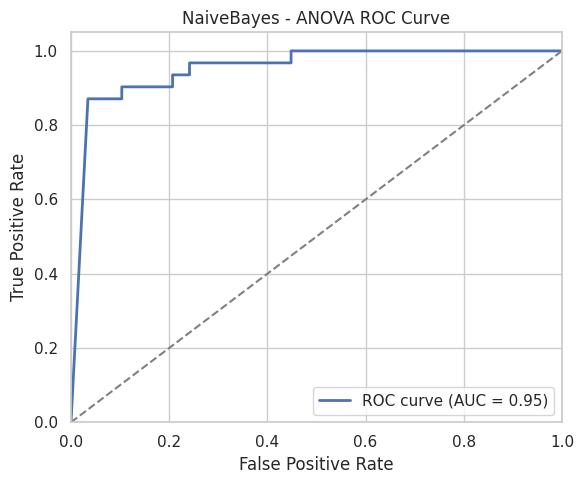

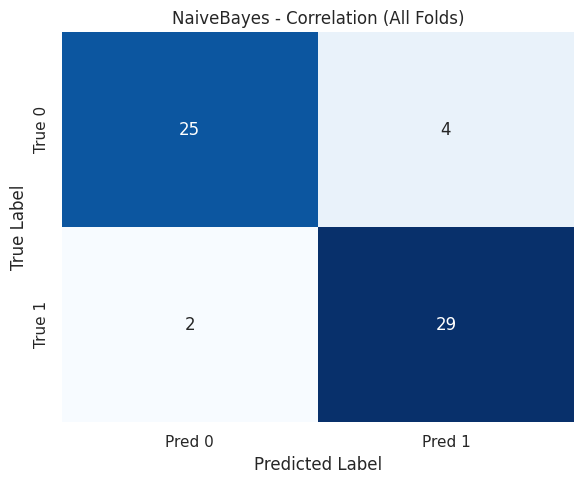

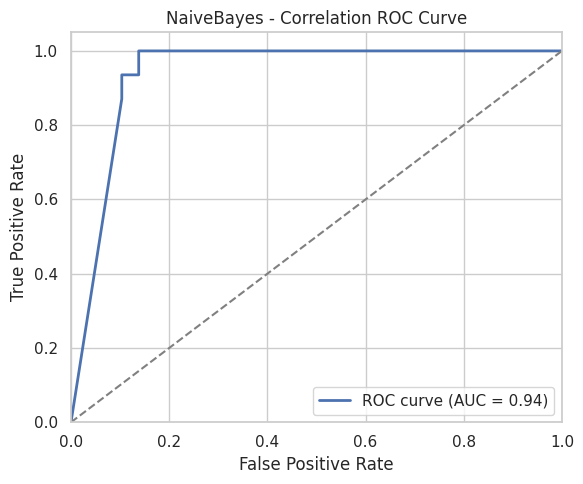

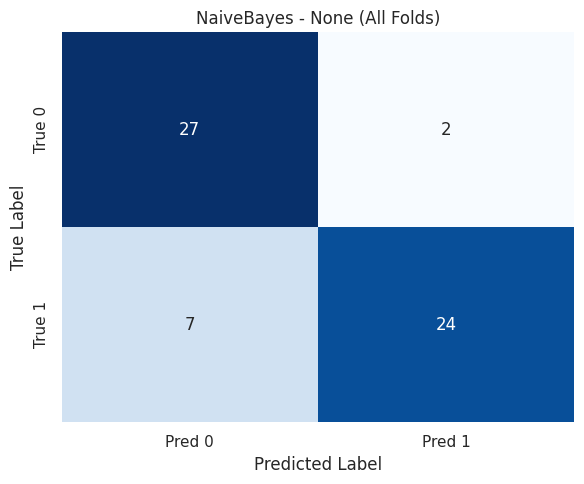

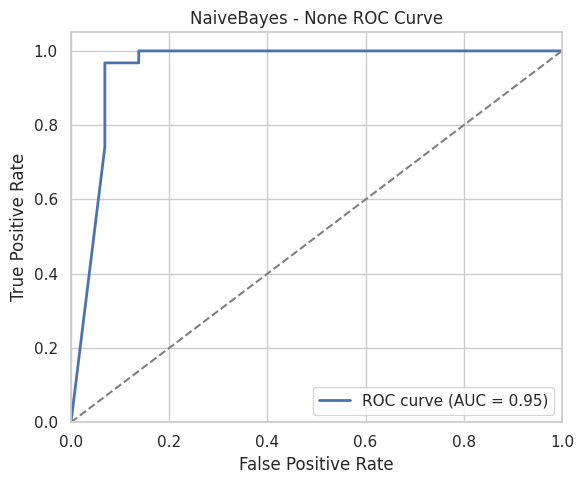

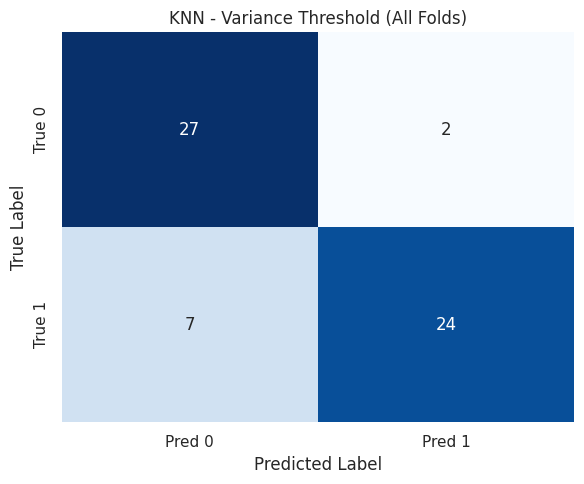

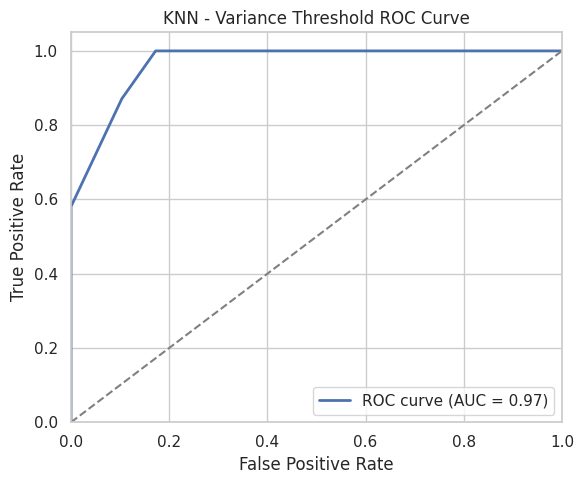

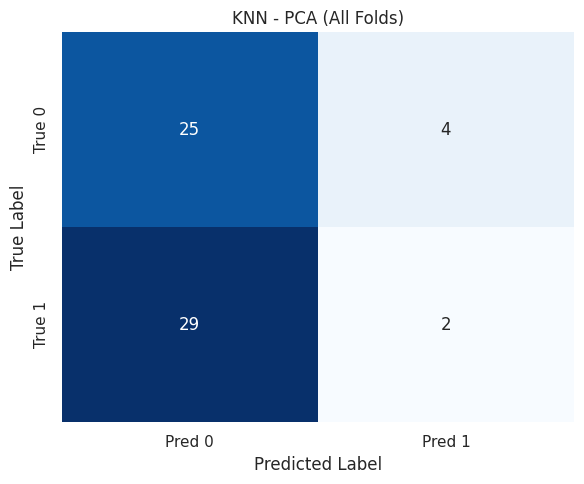

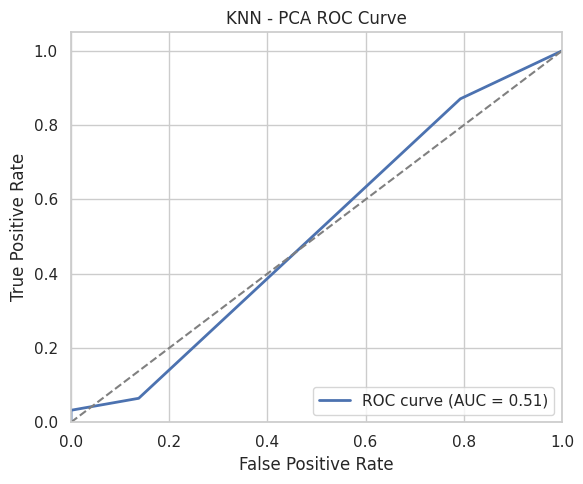

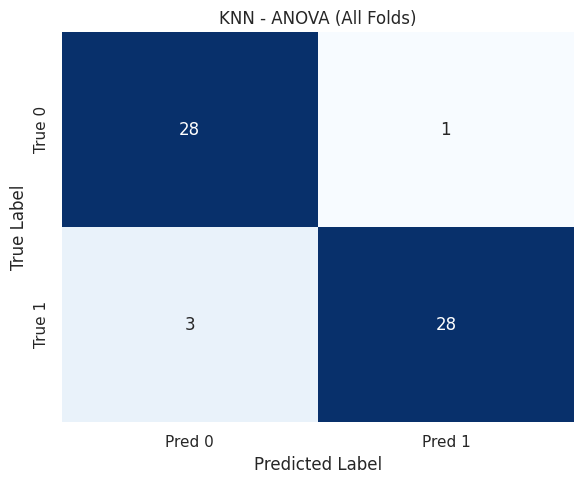

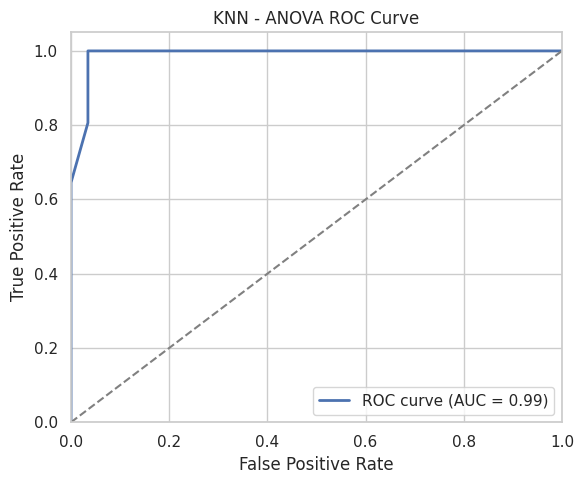

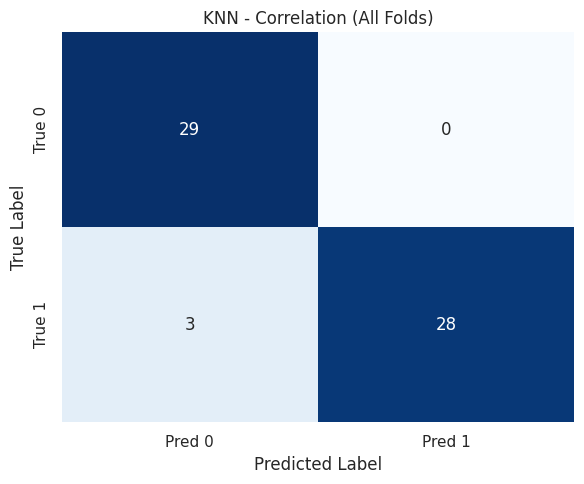

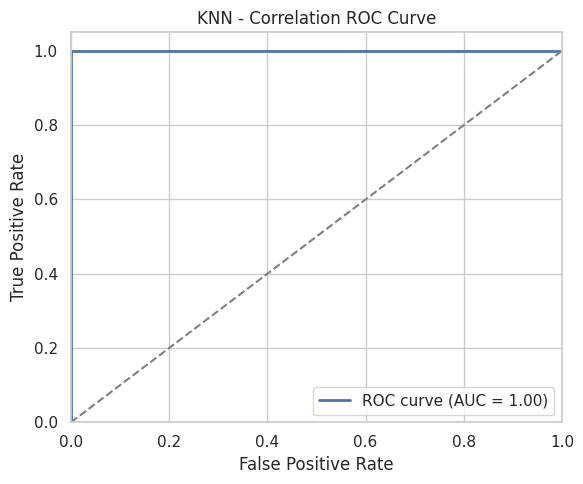

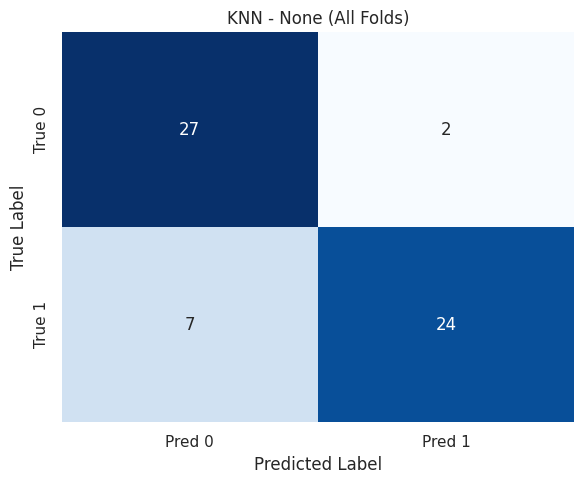

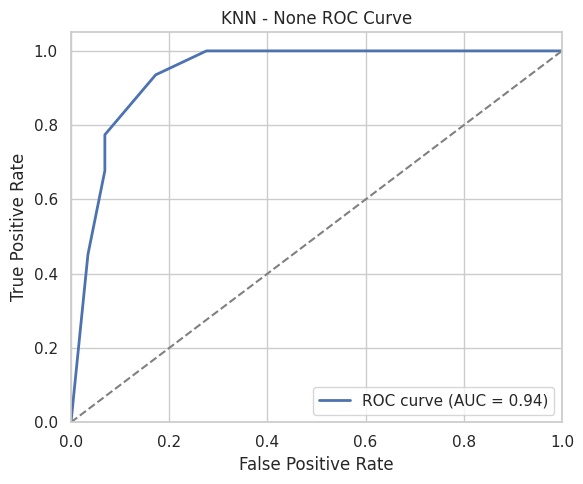

In [60]:
all_results = {}

for name, model in models.items():
    model_results = {}
    #print("#################################")
    spaces_left = len("#################################")-len(f"Evaluating {name}")-2
    #print("#"+ " "*(int(np.floor(spaces_left/2)))+ f"Evaluating {name}"+ " "*(int(np.ceil(spaces_left/2)))+ "#")
    #print("#################################\n")

    for method_name, df in feature_reductions.items():
        #print("#################################")
        spaces_left = len("#################################")-len(f"With {method_name}")-2
        #print("#"+ " "*(int(np.floor(spaces_left/2)))+ f"With {method_name}"+ " "*(int(np.ceil(spaces_left/2)))+ "#")
        #print("#################################\n")

        metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}

        all_y_true = []
        all_y_pred = []
        all_y_prob = []

        df = df.values
        for train_idx, test_idx in kf.split(df, df_Y):

            X_train, X_test = df[train_idx], df[test_idx]
            y_train, y_test = df_Y.iloc[train_idx], df_Y.iloc[test_idx]

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_proba = pipeline.predict_proba(X_test)[:, 1]

            metrics["accuracy"].append(accuracy_score(y_test, y_pred))
            metrics["precision"].append(precision_score(y_test, y_pred))
            metrics["recall"].append(recall_score(y_test, y_pred))
            metrics["f1"].append(f1_score(y_test, y_pred))

            all_y_prob = np.array(y_proba).flatten()
            all_y_true = np.array(y_test).flatten()
            all_y_pred = np.array(y_pred).flatten()

        model_results[method_name] = {"accuracy": np.mean(metrics["accuracy"]),
                                      "precision": np.mean(metrics["precision"]),
                                      "recall": np.mean(metrics["recall"]),
                                      "f1": np.mean(metrics["f1"])}

        #print(f"Accuracy: {model_results[method_name]['accuracy']:.3f}")
        #print(f"Precision: {model_results[method_name]['precision']:.3f}")
        #print(f"Recall: {model_results[method_name]['recall']:.3f}")
        #print(f"F1: {model_results[method_name]['f1']:.3f}\n")

        cm = confusion_matrix(all_y_true, all_y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"{name} - {method_name} (All Folds)")
        plt.tight_layout()
        plt.show()


        fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        sns.set(style='whitegrid')
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{name} - {method_name} ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

        #print()

    all_results[name] = model_results



Print the table with all acuracies from the different methods.

In [61]:
metrics_list = ["accuracy", "precision", "recall", "f1"]

# Generate and display a styled table for each metric
for metric in metrics_list:
    results_table = pd.DataFrame({
        model_name: {
            method: metrics[metric]
            for method, metrics in model_metrics.items()
        }
        for model_name, model_metrics in all_results.items()
    }).T

    results_table_styled = results_table.style \
        .format("{:.3f}") \
        .set_caption(f"Model {metric.capitalize()} by Feature Selection Method") \
        .set_properties(**{'text-align': 'center'}) \
        .background_gradient(cmap='Blues', subset=pd.IndexSlice[:, :])

    display(results_table_styled)

,Variance Threshold,PCA,ANOVA,Correlation,None
LogisticRegression,0.921,0.636,0.921,0.921,0.930
RandomForest,0.897,0.841,0.927,0.927,0.930
QDA,0.540,0.577,0.523,0.543,0.560
MLP,0.920,0.361,0.947,0.944,0.924
SVM,0.920,0.606,0.944,0.941,0.927
XGBoost,0.884,0.891,0.904,0.907,0.914
NaiveBayes,0.861,0.619,0.934,0.937,0.861
KNN,0.864,0.477,0.904,0.914,0.897


,Variance Threshold,PCA,ANOVA,Correlation,None
LogisticRegression,0.928,0.640,0.927,0.931,0.931
RandomForest,0.890,0.843,0.914,0.915,0.905
QDA,0.560,0.589,0.547,0.555,0.580
MLP,0.931,0.387,0.938,0.945,0.930
SVM,0.905,0.570,0.924,0.923,0.901
XGBoost,0.868,0.892,0.908,0.891,0.908
NaiveBayes,0.917,0.672,0.921,0.938,0.919
KNN,0.902,0.467,0.951,0.938,0.931


,Variance Threshold,PCA,ANOVA,Correlation,None
LogisticRegression,0.923,0.701,0.923,0.917,0.936
RandomForest,0.918,0.854,0.949,0.949,0.968
QDA,0.561,0.619,0.503,0.579,0.573
MLP,0.917,0.402,0.962,0.950,0.925
SVM,0.949,0.987,0.975,0.969,0.968
XGBoost,0.924,0.904,0.911,0.936,0.930
NaiveBayes,0.809,0.509,0.955,0.943,0.808
KNN,0.829,0.045,0.860,0.898,0.866


,Variance Threshold,PCA,ANOVA,Correlation,None
LogisticRegression,0.924,0.668,0.923,0.922,0.933
RandomForest,0.903,0.848,0.931,0.932,0.935
QDA,0.560,0.601,0.523,0.565,0.574
MLP,0.923,0.393,0.949,0.947,0.926
SVM,0.925,0.723,0.948,0.945,0.932
XGBoost,0.894,0.895,0.908,0.913,0.918
NaiveBayes,0.858,0.579,0.937,0.940,0.857
KNN,0.862,0.079,0.903,0.915,0.897
